In [ ]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re
import nltk
from nltk.corpus import stopwords

In [ ]:
# load data
df = pd.read_csv('/content/tokopedia-product-reviews-2019.csv')

# Load data mentah
df_raw = pd.read_csv("/content/tokopedia-product-reviews-2019.csv")

# Copy ke df untuk proses cleaning
df = df_raw.copy()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# data understanding
df.shape  #lihat ukuran baris dan kolom
df.head(5)   #lihat 5 baris pertama
df.info      # tipe data dan missing count
df.describe(include='all') #ringkasan statistik

,Unnamed: 0,text,rating,category,product_name,product_id,sold,shop_id,product_url
count,40607.000000,40607,40607.000000,40607,40607,4.060700e+04,40593,4.060700e+04,40607
unique,NaN,37301,NaN,5,3647,NaN,305,NaN,3664
top,NaN,Barang sesuai deskripsi,NaN,elektronik,TINTA / CATRIDGE HP 680 BLACK / COLOR ORIGINAL...,NaN,"3,2rb",NaN,https://www.tokopedia.com/sjkomputer/tinta-cat...
freq,NaN,57,NaN,15897,1312,NaN,1794,NaN,1312
mean,20443.690103,NaN,4.642574,NaN,NaN,1.985060e+08,NaN,1.342409e+06,NaN
std,11810.534919,NaN,0.732448,NaN,NaN,1.284990e+08,NaN,1.028990e+06,NaN
min,1.000000,NaN,1.000000,NaN,NaN,1.505048e+06,NaN,1.563000e+03,NaN
25%,10225.500000,NaN,4.000000,NaN,NaN,1.052222e+08,NaN,1.625610e+05,NaN
50%,20427.000000,NaN,5.000000,NaN,NaN,1.829377e+08,NaN,1.787060e+06,NaN
75%,30680.500000,NaN,5.000000,NaN,NaN,2.889640e+08,NaN,2.048686e+06,NaN


CEK DATA CLEANING


In [ ]:
print("jumlah baris awal:", len(df_raw))
print("jumlah baris sesudah di cleaning:", len(df))

jumlah baris awal: 40607
jumlah baris sesudah di cleaning: 40607


In [ ]:
#cek duplikat
df.duplicated().sum()

np.int64(0)

In [ ]:
#cek missing values
df.isnull().sum()

,0
Unnamed: 0,0
text,0
rating,0
category,0
product_name,0
product_id,0
sold,14
shop_id,0
product_url,0


In [ ]:
#cek tipe data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40607 entries, 0 to 40606
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    40607 non-null  int64 
 1   text          40607 non-null  object
 2   rating        40607 non-null  int64 
 3   category      40607 non-null  object
 4   product_name  40607 non-null  object
 5   product_id    40607 non-null  int64 
 6   sold          40593 non-null  object
 7   shop_id       40607 non-null  int64 
 8   product_url   40607 non-null  object
dtypes: int64(4), object(5)
memory usage: 2.8+ MB


In [ ]:
#cek outlier
print(df['rating'].unique())

[5 3 4 2 1]


In [ ]:
#cek konsistensi kategori
df['category'].value_counts()

,count
category,
elektronik,15897
fashion,8910
olahraga,7838
handphone,6136
pertukangan,1826


In [ ]:
#membuat kolom sentimen dari rating
def map_sentiment(r):
    if r >= 4:
        return 'Positive'
    elif r <= 2:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['rating'].apply(map_sentiment)

In [ ]:
#membuat kolom panjang review
df['review_len'] = df['text'].fillna('').apply(len)

In [ ]:
#lihat 5 baris pertama dengan kolom baru
df[['rating', 'sentiment', 'text', 'review_len']].head()

,rating,sentiment,text,review_len
0,5,Positive,Barang sesuai pesanan dan cepat sampai,38
1,5,Positive,Barang bagus harga murah,24
2,5,Positive,Paket rapi...mantap....cepat....sampe ke tujuan,47
3,5,Positive,ya saya puas dgn barangnya,26
4,5,Positive,Responya luar biasa b mantap,28


DATA CLEANING


In [ ]:
# drop duplikat
df.drop_duplicates()

,Unnamed: 0,text,rating,category,product_name,product_id,sold,shop_id,product_url,sentiment,review_len
0,1,Barang sesuai pesanan dan cepat sampai,5,pertukangan,Staples Dekorasi Staples Kayu + Refill 8mm - S...,418660637,1,1740837,https://www.tokopedia.com/shakaonline87/staple...,Positive,38
1,2,Barang bagus harga murah,5,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,416032545,11,1477109,https://www.tokopedia.com/juraganperkakas/stap...,Positive,24
2,3,Paket rapi...mantap....cepat....sampe ke tujuan,5,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,416032545,11,1477109,https://www.tokopedia.com/juraganperkakas/stap...,Positive,47
3,4,ya saya puas dgn barangnya,5,pertukangan,ALAT STAPLES TEMBAK &#40;AIR NAILER GUN&#41; O...,102279869,5,771395,https://www.tokopedia.com/kamarmesin/alat-stap...,Positive,26
4,5,Responya luar biasa b mantap,5,pertukangan,Isi Refill Staples Jok Kulit Motor / Staple Gu...,190679689,787,969999,https://www.tokopedia.com/mitrapersada/isi-ref...,Positive,28
...,...,...,...,...,...,...,...,...,...,...,...
40602,40889,gak bisa ditutup.. ukuran gak pas..,1,olahraga,MINERAL WATER POT WATER PURIFIER 28 liter BIO ...,144442054,2,648559,https://www.tokopedia.com/pusatdermawand/miner...,Negative,35
40603,40890,Penjual krg peduli dan brg jelek. Brg yg dikir...,1,olahraga,PANCI PRESTO IDEALIFE 7 LITER - IL 707 &#40; I...,313781913,1,648559,https://www.tokopedia.com/pusatdermawand/panci...,Negative,211
40604,40891,"pelayanan kurang sigap, berhari2 dr nanya baik...",1,olahraga,EXCIDER BIKE 2 - sepeda fitnes magnetic lipat ...,71873370,1,648559,https://www.tokopedia.com/pusatdermawand/excid...,Negative,294
40605,40892,"barang yg dikirim tsk sesuai wrn, kl memang dr...",1,olahraga,TOTAL FITNES ALAT FITNESS SIT UP BENCH TOTAL &...,201690705,2,648559,https://www.tokopedia.com/pusatdermawand/total...,Negative,434


In [ ]:
# ubah rating ke numeric
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

In [ ]:
# fix missing values
df = df.dropna(subset=['sold'])

EXPLORATORY DATA ANALYSIS

In [ ]:
# 1.distribusi rating
rating_counts = df['rating'].value_counts().sort_index()
rating_counts

,count
rating,
1,543
2,382
3,1825
4,7543
5,30300


In [ ]:
# 2.rata-rata rating per kategori produk
rating_by_cat = df.groupby('category')['rating'].agg(['count', 'mean', 'median']).sort_values('mean', ascending=False)
rating_by_cat

,count,mean,median
category,,,
elektronik,15897,4.757501,5.0
fashion,8896,4.674348,5.0
pertukangan,1826,4.643483,5.0
olahraga,7838,4.579740,5.0
handphone,6136,4.378422,5.0


In [ ]:
# top 10 produk paling banyak di review
top_reviewed = (
    df.groupby(['product_id','product_name'])
    .agg({'text':'count','rating':'mean'})
    .rename(columns={'text':'n_reviews'})
    .sort_values('n_reviews', ascending=False)
    .head(10)
)
top_reviewed



,,n_reviews,rating
product_id,product_name,,
159398204,TINTA / CATRIDGE HP 680 BLACK / COLOR ORIGINAL 100%,1312,4.865854
170467507,Gamepad single Usb M-Tech/stick laptop/stick pc/joystick,1113,4.684636
182937734,USB HUB 4 port USB 3.0 / USB HUB 3.0 &#40;4port&#41; DIGIGEAR HIGH QUALITY,1031,4.768186
159390512,TINTA / CATRIDGE HP 678 BLACK / COLOR ORIGINAL 100%,791,4.892541
189405731,Switch HUB TP LINK 5 Port TL-SF1005D 10/100Mbps Network Lan Internet,763,4.853211
55299234,Headset Bluetooth Mini S530 - Micro Sport Stereo Bluetooth Earphone,759,4.096179
266910555,NOKIA 130 dual sim handphone hp,638,4.073668
373026837,jam tangan pria Biden fashion analog bisnis pita jala - Biru,575,4.968696
469877650,Sepatu Casual Kets Sport Nike MD Runner / Waffle Trainer Hitam Putih,505,4.388119


VISUALISASI DENGAN PYTHON/PREVIEW SEBELUM KE TABLEAU


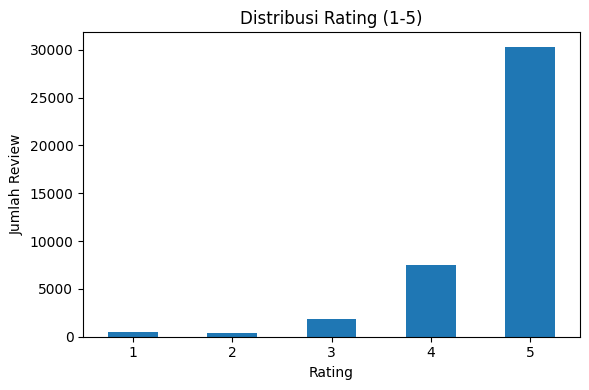

In [ ]:
# 1. distribusi rating(barchart)
import matplotlib.pyplot as plt

#hitung frekuensi per rating
rating_counts = df['rating'].value_counts().sort_index()

#plot
plt.figure(figsize=(6,4))                     # atur ukuran gambar (lebar, tinggi)
rating_counts.plot(kind='bar')                # plot bar chart (default colors)
plt.title("Distribusi Rating (1-5)")          # judul chart
plt.xlabel("Rating")                          # label sumbu-x
plt.ylabel("Jumlah Review")                   # label sumbu-y
plt.xticks(rotation=0)                        # putar nama xticks (0 derajat = horizontal)
plt.tight_layout()                            # rapikan layout
plt.savefig("dist_rating.png", dpi=300)       # simpan gambar (opsional)
plt.show()                                    # tampilkan chart

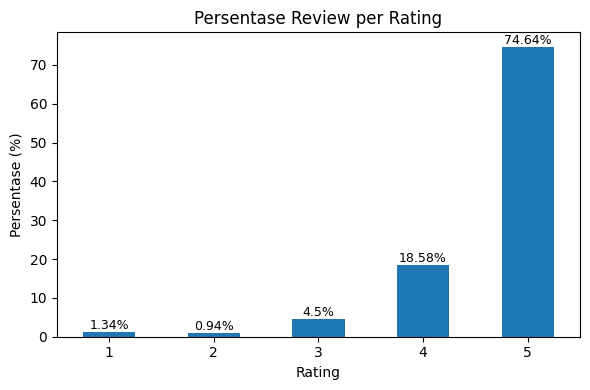

In [ ]:
# 2. persentase per rating(bar dengan label %)
total = len(df)
pct = (rating_counts / total * 100).round(2)

plt.figure(figsize=(6,4))
ax = pct.plot(kind='bar')
plt.title("Persentase Review per Rating")
plt.xlabel("Rating")
plt.ylabel("Persentase (%)")
plt.xticks(rotation=0)

# tambahkan label persentase di atas tiap bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height}%", (p.get_x() + p.get_width()/2, height),
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


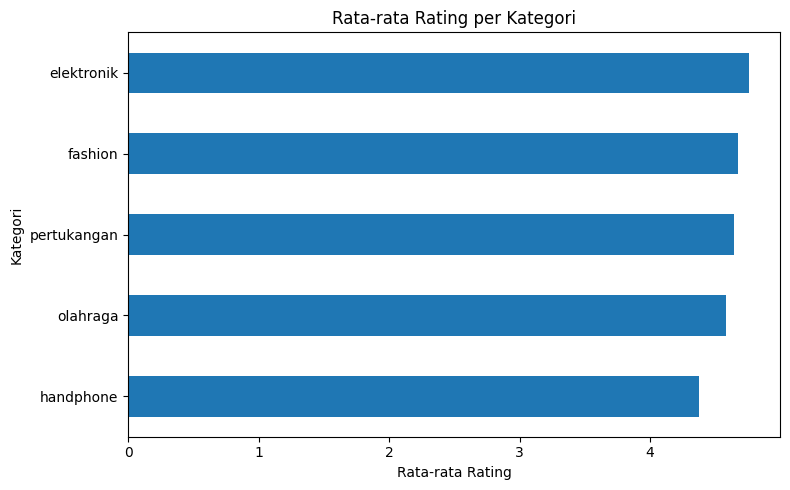

In [ ]:
# 3. rata-rata rating per kategori
rating_by_cat = df.groupby('category')['rating'].agg(['count','mean','median']).sort_values('mean', ascending=False)

plt.figure(figsize=(8,5))
ax = rating_by_cat['mean'].plot(kind='barh')  # bar horizontal
plt.title("Rata-rata Rating per Kategori")
plt.xlabel("Rata-rata Rating")
plt.ylabel("Kategori")
plt.gca().invert_yaxis()                       # urut dari tertinggi ke bawah
plt.tight_layout()
plt.show()


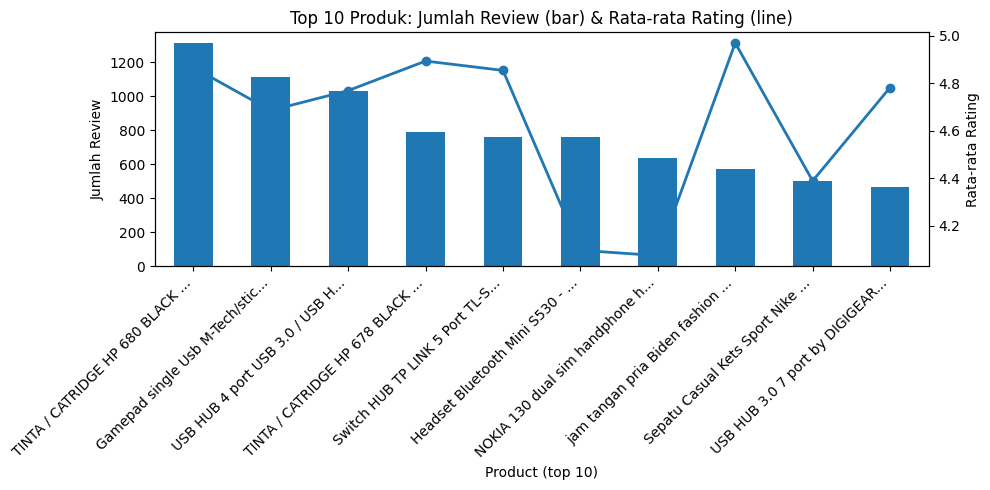

In [ ]:
#top 10 produk berdasarkan jumlah review
top_reviewed = (
    df.groupby(['product_id','product_name'])
      .agg(n_reviews=('text','count'), avg_rating=('rating','mean'))
      .sort_values('n_reviews', ascending=False)
      .head(10)
)

plt.figure(figsize=(10,5))
ax = top_reviewed['n_reviews'].plot(kind='bar')         # bar = jumlah review
ax.set_ylabel("Jumlah Review")
ax.set_xlabel("Product (top 10)")
ax.set_xticklabels([f"{i[1][:30]}..." for i in top_reviewed.index], rotation=45, ha='right')  # potong nama agar tidak melebar

# secondary axis untuk rata-rata rating
ax2 = ax.twinx()
ax2.plot(range(len(top_reviewed)), top_reviewed['avg_rating'], marker='o', linestyle='-', linewidth=2)
ax2.set_ylabel("Rata-rata Rating")

plt.title("Top 10 Produk: Jumlah Review (bar) & Rata-rata Rating (line)")
plt.tight_layout()
plt.show()


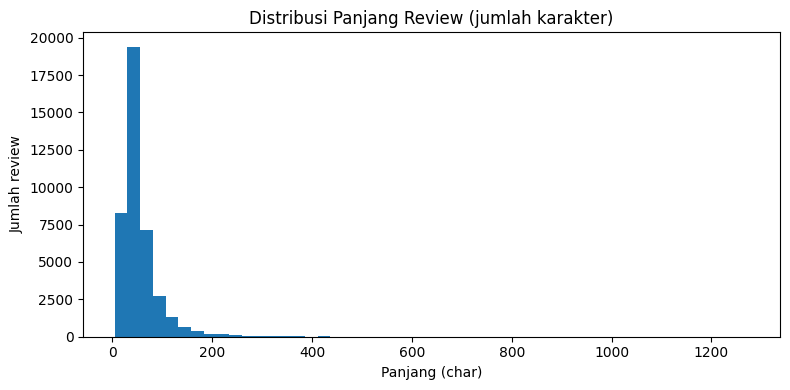

<Figure size 800x400 with 0 Axes>

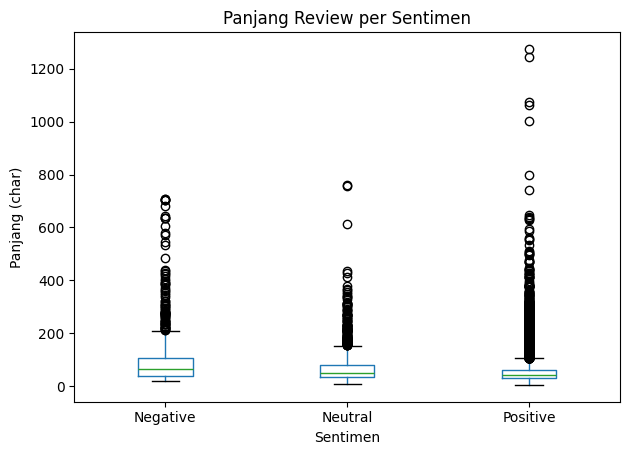

In [ ]:
#distribusi panjang review
plt.figure(figsize=(8,4))
plt.hist(df['review_len'].dropna(), bins=50)  # histogram panjang review
plt.title("Distribusi Panjang Review (jumlah karakter)")
plt.xlabel("Panjang (char)")
plt.ylabel("Jumlah review")
plt.tight_layout()
plt.show()

# Boxplot review_len per sentiment (Positive/Neutral/Negative)
plt.figure(figsize=(8,4))
df.boxplot(column='review_len', by='sentiment', grid=False)
plt.suptitle("")  # hilangkan default suptitle
plt.title("Panjang Review per Sentimen")
plt.xlabel("Sentimen")
plt.ylabel("Panjang (char)")
plt.tight_layout()
plt.show()


In [ ]:
#menyimpan summary CSV yang di import ke Tableau
# rating per kategori → reset index supaya category jadi kolom
rating_by_cat.reset_index().to_csv("rating_by_category.csv", index=False, encoding='utf-8')

# top products
top_reviewed.reset_index().assign(product_name=lambda df_: df_['product_name'].str.slice(0,100)).to_csv("top_reviewed_products.csv", index=False, encoding='utf-8')

# cleaned full dataset (jika ingin)
df.to_csv("tokopedia_cleaned.csv", index=False, encoding='utf-8')


In [ ]:
# cek apakah file berhasil tersimpan
import os
print(os.listdir("/content"))


['.config', 'dist_rating.png', 'tokopedia-product-reviews-2019.csv', 'rating_by_category.csv', 'tokopedia_cleaned.csv', 'top_reviewed_products.csv', 'sample_data']


In [ ]:
from google.colab import files
files.download(output_name)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>